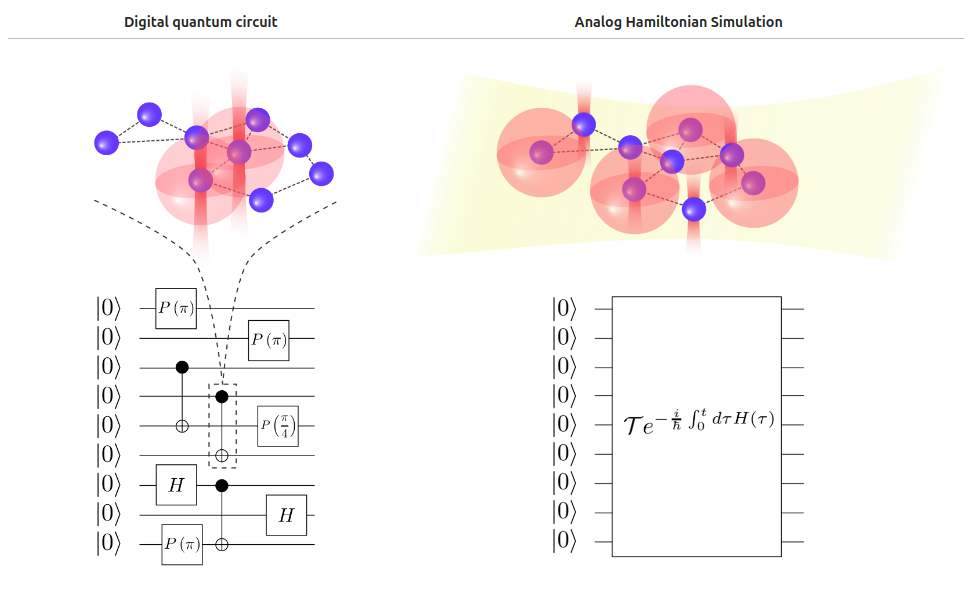

Image credit: AWS github

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

We have a chain of atoms. The goal is to study the anti-feromagnetic order of this spins (up, down respectively).

Ground state: down spin state.(|0>)

Excited state: Up spin state.(|1>)



## **Arrangement of atoms**

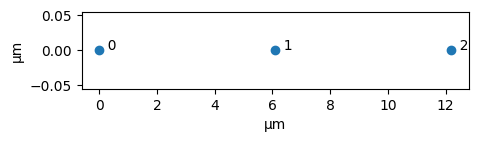

In [2]:
import matplotlib.pyplot as plt

# For realizing the AFM order, the atomic spacing is typically
# chosen between 6 and 7 micrometers. The interested readers are 
# encouraged to try other values of atomic spacing!
a = 6.1 # μm
num_atoms = 3
coords = []
for k in range(num_atoms):
    coords.append([k * a, 0])

plt.figure(figsize=(5,1))    

plt.scatter([x for x, y in coords], [y for x, y in coords])

# Add the labels for the atoms            
for idx, site in enumerate(coords):
    plt.text(site[0], site[1], f"  {idx}", fontsize=10)

plt.xlabel("μm")
plt.ylabel("μm")
plt.show()

## **setting the parameters for driving Hamiltonian (light pulse)**

In [3]:
import pennylane.numpy as np

# Rydberg interaction constant
C6 = 862619.79 # MHz μm^6

# Constraints for the driving fields with SI unit, the unit used by Braket
amplitude_max = 1.58e7 # rad/second
detuning_max = 1.25e8 # rad/second
time_max_second = 4e-6 # second


def angular_SI_to_MHz(angular_SI):
    """Converts a value in rad/s or (rad/s)/s into MHz or MHz/s"""
    return angular_SI / (2 * np.pi) * 1e-6

# Pennylane uses microseconds for time so the unit of time is converted from second to microsecond
time_max = time_max_second * 1e6 # microsecond

# Pennylane uses MHz for amplitude and detuning so their units are converted from rad/second to MHz
amplitude_max = angular_SI_to_MHz(amplitude_max) # MHz
detuning_max = angular_SI_to_MHz(detuning_max) # MHz

print(f"amplitude_max = {round(amplitude_max, 2)} MHz")
print(f"detuning_max  = {round(detuning_max, 2)} MHz")
print(f"time_max      = {time_max} μs")

amplitude_max = 2.51 MHz
detuning_max  = 19.89 MHz
time_max      = 4.0 μs


There are two important remarks for defining the differentiable functions in PennyLane. First, mathematical functions, such as trigonometric functions, should be explicitly defined as JAX functions for them to be differentiable.

In [4]:
import jax.numpy as jnp
import jax

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)

def ryd_amplitude(p, t):
    """Parametrized function for amplitude"""
    return p[0] * (1-(1-jnp.sin(jnp.pi * t/time_max)**2)**(p[1]/2))

def ryd_detuning(p, t):
    """Parametrized function for detuning"""
    return 10_000 #p[0] * jnp.arctan(p[1] * (t-time_max/2)) / (jnp.pi/2)

**Plot the amplitude and detuning variation with time**

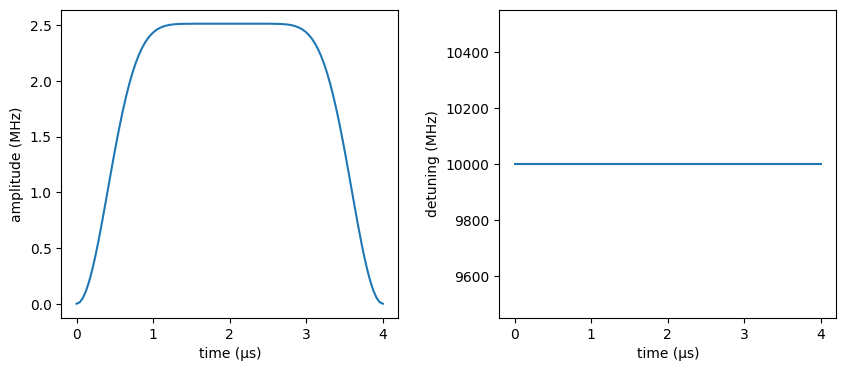

In [5]:
vis_time = np.linspace(0, time_max, 100)

# These parameters are chosen arbitrarily for demonstration purpose.
# The readers are encouraged to try out other parameters!
amplitude_param = [amplitude_max, 10]
detuning_param = [detuning_max * 2/3, 1.45]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_param, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_param, t) for t in vis_time])
axes[1].set_ylabel("detuning (MHz)")
axes[1].set_xlabel("time (μs)")
fig.subplots_adjust(wspace=0.3)
plt.show()

## **Drive Hamiltonian**

In [6]:
import pennylane as qml

global_drive = qml.pulse.rydberg_drive(amplitude=ryd_amplitude, phase=0, detuning=ryd_detuning, wires=range(len(coords)))

In [7]:
shots = 1000

# Introduce the PennyLane local simulator
simulator_pl = qml.device("default.qubit.jax", wires=len(coords), shots=shots)

ts = [0, time_max]

@qml.qnode(simulator_pl)
def state_evolution_detuned():

    # Use qml.evolve to find the final state of the atom after interacting with the pulse
    qml.evolve(global_drive)([amplitude_param, detuning_param], ts)

    return qml.probs(wires=range(num_atoms))

result = state_evolution_detuned()

print(f"The final state is \n {result} \n Which is the ground state properly initialized.")

The final state is 
 [1. 0. 0. 0. 0. 0. 0. 0.] 
 Which is the ground state properly initialized.


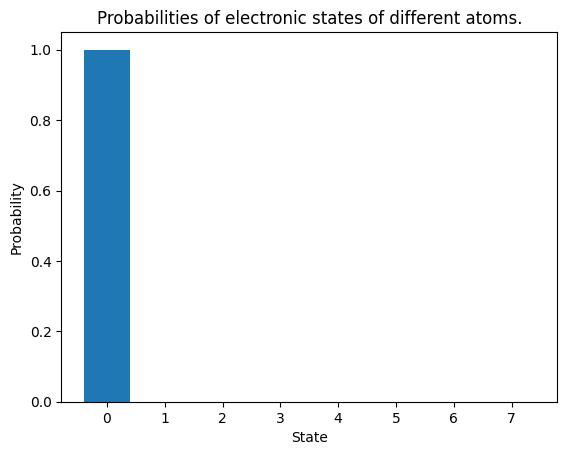

In [8]:
import matplotlib.pyplot as plt

plt.bar(range(2**num_atoms), result)
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Probabilities of electronic states of different atoms.')
# plt.xticks(range(2**n), ['00', '01', '10', '11'])
plt.show()

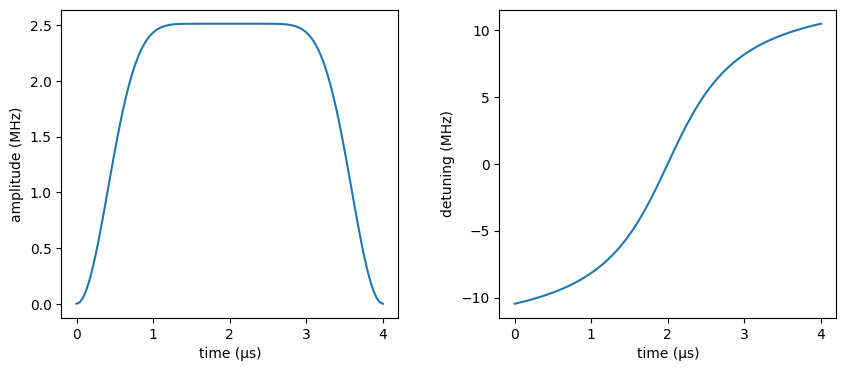

In [9]:
def ryd_detuning(p, t):
    """Parametrized function for detuning"""
    return p[0] * jnp.arctan(p[1] * (t-time_max/2)) / (jnp.pi/2)

vis_time = np.linspace(0, time_max, 100)

# These parameters are chosen arbitrarily for demonstration purpose.
# The readers are encouraged to try out other parameters!
amplitude_param = [amplitude_max, 10]
detuning_param = [detuning_max * 2/3, 1.45]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_param, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_param, t) for t in vis_time])
axes[1].set_ylabel("detuning (MHz)")
axes[1].set_xlabel("time (μs)")
fig.subplots_adjust(wspace=0.3)
plt.show()

In [10]:
global_drive = qml.pulse.rydberg_drive(amplitude=ryd_amplitude, phase=0, detuning=ryd_detuning, wires=range(len(coords)))

In [11]:
H_ryd = global_drive + qml.pulse.rydberg_interaction(coords, interaction_coeff=C6)

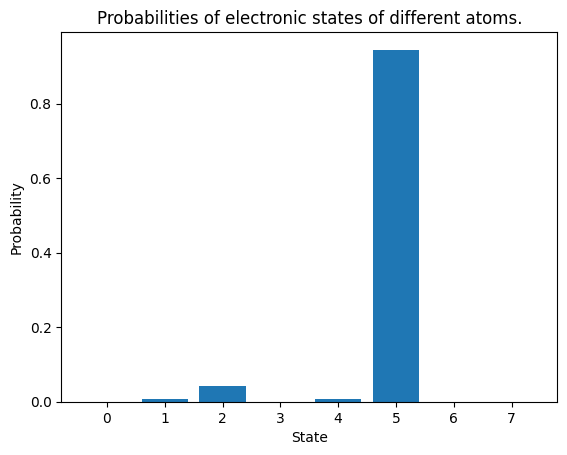

In [12]:
ts = [0, time_max]

@qml.qnode(simulator_pl)
def program(detuning_param, amplitude_param = amplitude_param, ts = ts):
    qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
    return qml.probs(wires=range(num_atoms)), qml.counts()

result = program(detuning_param=detuning_param)

plt.bar(range(2**num_atoms), result[0])
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Probabilities of electronic states of different atoms.')
# plt.xticks(range(2**n), ['00', '01', '10', '11'])
plt.show()

**Note: For a chain of atoms, the average Rydberg probability of the ideal AFM order forms an alternating pattern of zeros and ones. In particular, atoms in the odd-index and even-index sites tend to be in the ground and Rydberg states, respectively.**

In [13]:
result[1]

{'001': 7, '010': 41, '100': 7, '101': 945}

# **Variational algorithm for AHS**

In [14]:
# The cost:
# Initialize the cost function
H_cost = 0
for i in range(len(coords)-2):
    # Add the contribution from each domain wall
    H_cost += qml.prod(qml.Projector([1], wires=[i]) - 1/2, qml.Projector([1], wires=[i+1]) -1/2)

In [15]:
# Define the PennyLane local simulator
dev = qml.device("default.qubit.jax", wires=range(len(coords)))

# Define the qnode that evolves the Rydberg system, followed by calculating the cost function
@qml.qnode(dev, interface="jax")
def program_cost(detuning_param, amplitude_param = amplitude_param, ts = ts):
    qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
    return qml.expval(H_cost)

In [16]:
theta = detuning_param.copy() 
initial_cost = program_cost(theta)
print(f"The initial parameter for detuning = {theta}")
print(f"The initial cost value             = {initial_cost}")

The initial parameter for detuning = [13.262911924324612, 1.45]
The initial cost value             = -0.24514498548638144


**Classical optimization**

In [17]:
value_and_grad = jax.jit(jax.value_and_grad(program_cost))

# Compile the value_and_grad function
_, _ = value_and_grad(theta)

import optax

n_epochs = 10

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1e-1)
schedule1 = optax.constant_schedule(5e-1)
schedule = optax.join_schedules([schedule0, schedule1], [10])
optimizer = optax.nadam(learning_rate=schedule)
opt_state = optimizer.init(theta)

Running the optimization:

In [18]:
energy = np.zeros(n_epochs + 1)
energy[0] = program_cost(theta)
gradients = np.zeros(n_epochs)

## Optimization loop
print("epoch  expectation")
for n in range(n_epochs):
    val, grad_program = value_and_grad(theta)
    updates, opt_state = optimizer.update(grad_program, opt_state)
    theta = optax.apply_updates(theta, updates)

    energy[n + 1] = val
    gradients[n] = np.mean(np.abs(grad_program))

    print(n, "   ", val)
    
print(f"The final parameter for detuning = {[float(i) for i in theta]}")

epoch  expectation
0     -0.24514498548638028
1     -0.24658980900177996
2     -0.24753480762523045
3     -0.24830002742157636
4     -0.248873057400624
5     -0.249307016230045
6     -0.2495738708145979
7     -0.2497865223765981
8     -0.24988958187309035
9     -0.2499433031598198
The final parameter for detuning = [12.385822105840619, 0.5258569839841823]


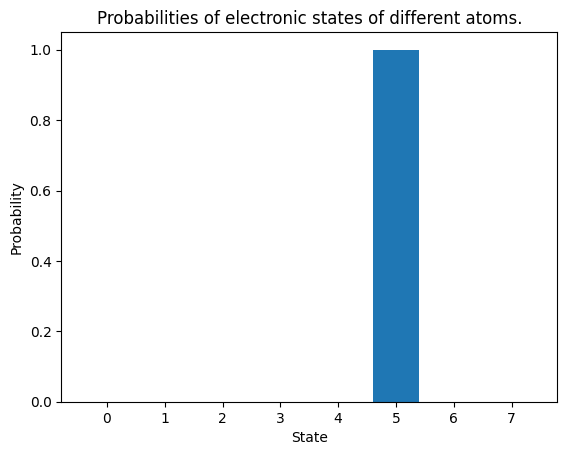

In [19]:
ts = [0, time_max]

@qml.qnode(simulator_pl)
def program(detuning_param, amplitude_param = amplitude_param, ts = ts):
    qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
    return qml.probs(wires=range(num_atoms)), qml.counts()

result = program(detuning_param=theta)

plt.bar(range(2**num_atoms), result[0])
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Probabilities of electronic states of different atoms.')
# plt.xticks(range(2**n), ['00', '01', '10', '11'])
plt.show()

# **Running on Aquila**

In [20]:
from braket.devices import Devices
device_arn = Devices.QuEra.Aquila

In [21]:
# from braket.aws import AwsDevice
# AwsDevice(device_arn).is_available

In [22]:
# AwsDevice(device_arn).queue_depth().jobs

In [23]:
# shots = 100
# aquila = qml.device("braket.aws.qubit",device_arn=device_arn,wires=len(coords),shots = shots)


# @qml.qnode(aquila)
# def program(detuning_param, amplitude_param = amplitude_param, ts = ts):
#     qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
#     return qml.probs(wires=range(num_atoms)), qml.counts()

# result = program(detuning_param=theta)

# plt.bar(range(2**num_atoms), result[0])
# plt.xlabel('State')
# plt.ylabel('Probability')
# plt.title('Probabilities of electronic states of different atoms.')
# # plt.xticks(range(2**n), ['00', '01', '10', '11'])
# plt.show()